## A Yen For The Future

### Time Series Analysis

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

#### Return Forecasting: Read Historical Daily Yen Futures Data

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
path = Path("~/Desktop/yen.csv")

yen_futures = pd.read_csv(path, index_col="Date", infer_datetime_format=True, parse_dates=True)

yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


### Return Forecasting: Initial Time-Series Plotting

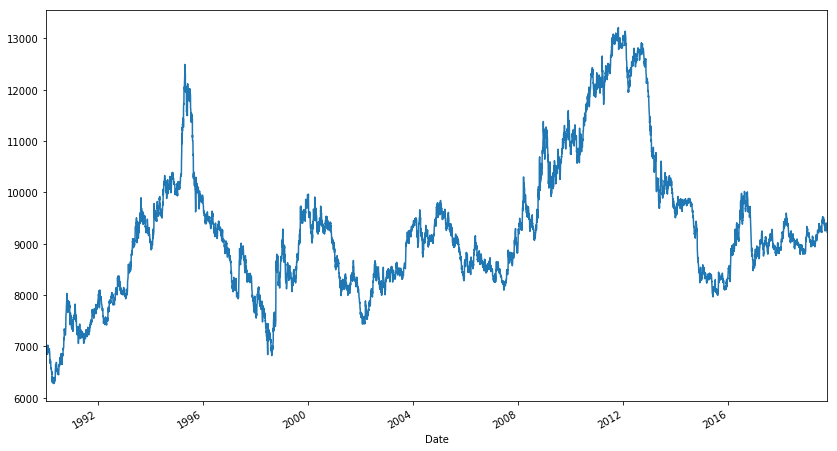

In [5]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot(figsize=(14,8))
plt.show()

### Decomposition Using a Hodrick-Prescott Filter

In [6]:
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
import statsmodels.api as sm
noise, trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [7]:
df = pd.DataFrame(yen_futures['Settle'])

In [8]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
noise = pd.DataFrame(noise)
noise.rename(columns={'Settle_cycle':'Noise'}, inplace=True)

trend = pd.DataFrame(trend)
trend.rename(columns={'Settle_trend':'Trend'}, inplace=True)

In [9]:
hp = pd.concat([df, noise, trend], axis=1)

In [10]:
hp.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


In [ ]:
# Could do this way and then plot as well
hp[['Settle', 'Noise', 'Trend']]["2015-01-01":]

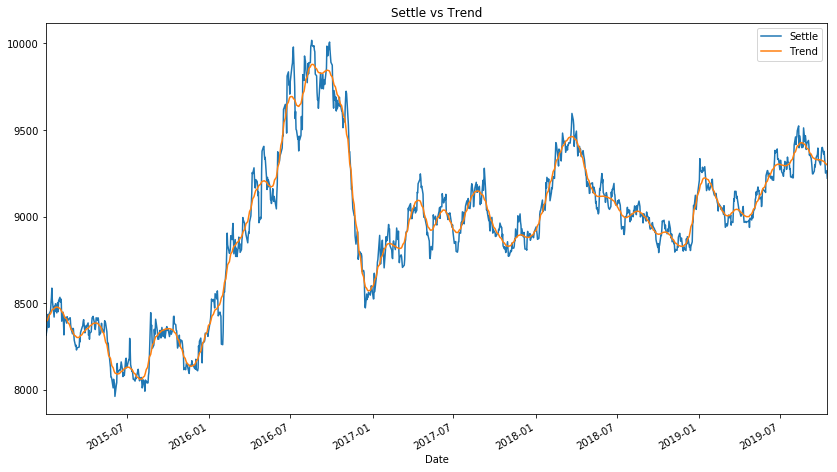

In [17]:
# Plot the Settle Price vs. the Trend for 2015 to the present
hp.loc["2015-01-01":].plot(y=['Settle', 'Trend'],figsize=(14,8), title="Settle vs Trend")
plt.show()

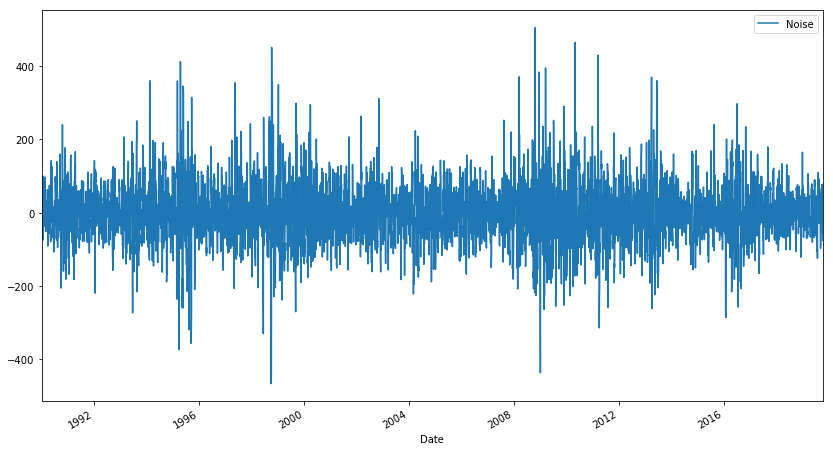

In [18]:
# Plot the Settle Noise
noise.plot(figsize=(14,8))
plt.show()

### Forecasting Returns using an ARMA Model

In [19]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [20]:
# Import ARMA from statsmodels
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 01 Sep 2020   AIC                          15798.142
Time:                        18:16:31   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3062      1.277     -0.240      0.811      -2.809       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2946      1.277      0.231      0.818      -2.208       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3354           +0.0000j            3.3354            0.5000
AR.2         -157.2438           +0.0000j          157.2438            0.5000
MA.1           -3.3944           +0.0000j            3.3944            0.5000
-----------------------------------------------------------------------------
"""

In [21]:
# Get array for 5 day forecast
results.forecast(steps=5)

(array([0.01229478, 0.00543669, 0.00661781, 0.00626926, 0.00637372]),
 array([0.69187027, 0.69191657, 0.69191749, 0.69191757, 0.69191758]),
 array([[-1.34374604,  1.3683356 ],
        [-1.35069486,  1.36156824],
        [-1.34951556,  1.36275117],
        [-1.34986426,  1.36240278],
        [-1.34975981,  1.36250726]]))

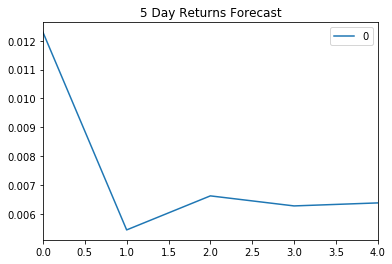

In [22]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")
plt.show()

### Forecasting the Settle Price using an ARIMA Model

In [23]:
from statsmodels.tsa.arima_model import ARIMA

In [24]:
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(df.Settle.values, order=(5,1,1))

# Fit the model
result = model.fit()

# Print the model summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Tue, 01 Sep 2020   AIC                          83905.238
Time:                        18:16:34   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3162      0.700      0.452      0.651      -1.056       1.688
ar.L1.D.y      0.2821      0.699      0.403      0.687      -1.088       1.653
ar.L2.D.y      0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.y     -0.0127      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.y     -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.y     -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.y     -0.2971      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8917           -1.3787j            2.3408           -0.1002
AR.2            1.8917           +1.3787j            2.3408            0.1002
AR.3           -2.2695           -3.0212j            3.7787           -0.3525
AR.4           -2.2695           +3.0212j            3.7787            0.3525
AR.5          -11.0489           -0.0000j           11.0489           -0.5000
MA.1            3.3655           +0.0000j            3.3655            0.0000
-----------------------------------------------------------------------------
"""

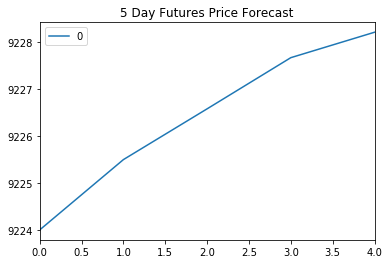

In [25]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(result.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")
plt.show()

### Volatility Forecasting with GARCH

In [26]:
import arch
from arch import arch_model

In [27]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
res = model.fit(disp="off")

# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Tue, Sep 01 2020   Df Residuals:                     7510
Time:                        18:16:35   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [28]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [29]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = res.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts

In [30]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [31]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15 00:00:00
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


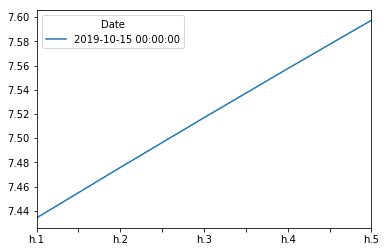

In [32]:
# Plot the final forecast
final.plot()

## Regression Analysis: Seasonal Effects with Sklearn Linear Regression

In [33]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [35]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    path, index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [36]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


### Data Preparation

#### Returns

In [61]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns_2 = (yen_futures[["Settle"]].pct_change() * 100)
returns_2 = returns.replace(-np.inf, np.nan).dropna()
returns_2 = returns_2.rename(columns={'Settle' : 'Return'})
returns_2.tail()

,Return
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [67]:
comb = pd.concat([yen_futures, returns_2], axis=1)
comb.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0,NaN
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0,0.584197
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0,1.756933
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0,-0.827626
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0,0.129496


### Lagged Returns

In [74]:
# Create a lagged return using the shift function
comb['Lag_Return'] = comb.Return.shift()
comb = comb.dropna()
comb.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lag_Return
Date,,,,,,,,,,
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.327970,0.020502


### Train Test Split

In [82]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = comb[:'2017']
test = comb['2018':]

In [83]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):


In [84]:
X_train = train["Lag_Return"].to_frame()
X_test = test["Lag_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [86]:
X_train.head()

,Lag_Return
Date,
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
2014-02-25,0.020502


### Linear Regression Model

In [87]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Making predictions using the Testing Data

In [88]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [89]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002D10A0F4808>,
      dtype=object)

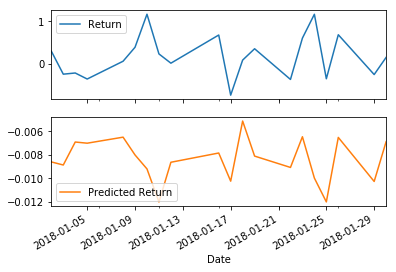

In [91]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True)

### Out-of-Sample Performance

In [92]:
from sklearn.metrics import mean_squared_error

# Calculate the mean_squared_error (MSE) on actual versus predicted test "y"
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.4154832784856737


### In-Sample Performance

In [94]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}") 

In-sample Root Mean Squared Error (RMSE): 0.5963660785073426
